# Cell 0 - Accumulation Signal Sandbox
Explore alternate short-signal formulas using daily_metrics data (read-only). No database writes.

In [41]:
# Cell 1 - Imports and Configuration
from pathlib import Path
import sys

import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

project_root = Path.cwd()
if (project_root / 'darkpool_analysis').exists():
    sys.path.insert(0, str(project_root))
elif (project_root.parent / 'darkpool_analysis').exists():
    sys.path.insert(0, str(project_root.parent))
elif (project_root.parent.parent / 'darkpool_analysis').exists():
    sys.path.insert(0, str(project_root.parent.parent))

from darkpool_analysis.config import load_config

config = load_config()

TICKER = 'TQQQ'
START_DATE = '2025-11-18'
END_DATE = '2025-12-31'
DB_PATH = config.db_path

# Buy/Sell signal mode
BUY_SELL_SIGNAL = 'Mean_Threshold'  # 'Mean_Threshold' or 'Rolling_Zscore'

# Median-threshold settings
THRESHOLD_K = 1.0
THRESHOLD_K_NEG = 1.0

# Rolling Z-score settings (used when BUY_SELL_SIGNAL = 'Rolling_Zscore')
ROLLING_WINDOW_DAYS = 20
ZSCORE_K_BUY = 1.8
ZSCORE_K_SELL = 1.8
ZSCORE_MIN_PERIODS = 0  # defaults to ROLLING_WINDOW_DAYS

# Rolling mean line settings (used when BUY_SELL_SIGNAL = 'Rolling_Zscore')
ROLLING_MEAN_WINDOW_DAYS = ROLLING_WINDOW_DAYS
ROLLING_MEAN_SHIFT_DAYS = -1  # use prior days for forward-valid mean

# Text scaling for 30 days
AUTO_TEXT_SCALE = True  # scale text with figure width
BASE_FIG_WIDTH = 12.0
TEXT_SCALE_MIN = 1.0
TEXT_SCALE_MAX = 3.5
TEXT_SCALE_POWER = 6  # exponent for width-based scaling

# # Text scaling for 1 year
# AUTO_TEXT_SCALE = True  # scale text with figure width
# BASE_FIG_WIDTH = 12.0
# TEXT_SCALE_MIN = 1.0
# TEXT_SCALE_MAX = 3.5
# TEXT_SCALE_POWER = 6  # exponent for width-based scaling

# X-axis labeling
MAX_X_LABELS = 90  # keep all labels up to this count

# Figure sizing
FIG_HEIGHT_RATIO = 1.0  # height = width * ratio
FIG_DPI = 100
FIGSIZE_PX = None  # None, or (width_px, height_px) to override






In [42]:
# Cell 2 - Styling Constants and Helper Functions
import matplotlib.dates as mdates
import math
from scipy.interpolate import PchipInterpolator

COLORS = {
    'background': '#0f0f10',
    'panel_bg': '#141416',
    'text': '#e6e6e6',
    'text_muted': '#8b8b8b',
    'grid': '#2a2a2d',
    'white': '#ffffff',
    'green': '#00ff88',
    'red': '#ff6b6b',
    'yellow': '#ffd700',
    'cyan': '#00d4ff',
    'orange': '#ff9f43',
    'purple': '#b026ff',
    'neutral': '#6b6b6b',
    'blue': '#4aa3ff',
}
GRID_ALPHA = 0.18
OHLC_LINE_WIDTH = 1.2


def _compute_fig_width(day_count):
    if day_count <= 0:
        return 12.0
    buckets = int(np.ceil(day_count / 50))
    return 12.0 * max(1, buckets)


def _apply_axis_style(ax):
    scale = globals().get('TEXT_SCALE', 1.0)
    ax.set_facecolor(COLORS['panel_bg'])
    ax.tick_params(colors=COLORS['text'], labelsize=9 * scale)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(COLORS['grid'])
    ax.spines['bottom'].set_color(COLORS['grid'])
    ax.grid(True, alpha=GRID_ALPHA, color=COLORS['grid'], linestyle='--')


def _apply_accum_axis_style(ax):
    scale = globals().get('TEXT_SCALE', 1.0)
    ax.set_facecolor(COLORS['panel_bg'])
    ax.tick_params(colors=COLORS['text'], labelsize=9 * scale)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(COLORS['grid'])
    ax.spines['bottom'].set_color(COLORS['grid'])
    ax.grid(True, axis='y', alpha=GRID_ALPHA, color=COLORS['grid'], linestyle='-')
    ax.grid(False, axis='x')


def _format_plain_int(value):
    if pd.isna(value):
        return 'NA'
    return f'{value:,.0f}'.replace(',', '')


def _plot_smooth_line(ax, x_values, values, color, valid_mask, linewidth=1.0, alpha=0.7, zorder=3, linestyle='-'):
    """Plot a smooth PCHIP-interpolated line through valid data points."""
    mask = np.asarray(valid_mask)
    if mask.sum() >= 3:
        valid_x = x_values[mask]
        valid_values = values[mask]

        if pd.api.types.is_datetime64_any_dtype(valid_x):
            x_nums = mdates.date2num(pd.to_datetime(valid_x))
            x_dense = np.linspace(x_nums.min(), x_nums.max(), 150)
            x_smooth = np.unique(np.concatenate([x_nums, x_dense]))
            interp = PchipInterpolator(x_nums, np.asarray(valid_values, dtype=float))
            y_smooth = interp(x_smooth)
            x_plot = mdates.num2date(x_smooth)
        else:
            x_nums = np.asarray(valid_x, dtype=float)
            x_dense = np.linspace(x_nums.min(), x_nums.max(), 150)
            x_smooth = np.unique(np.concatenate([x_nums, x_dense]))
            interp = PchipInterpolator(x_nums, np.asarray(valid_values, dtype=float))
            y_smooth = interp(x_smooth)
            x_plot = x_smooth

        ax.plot(
            x_plot,
            y_smooth,
            color=color,
            linewidth=linewidth,
            alpha=alpha,
            zorder=zorder,
            linestyle=linestyle,
        )
    else:
        ax.plot(
            x_values[mask],
            values[mask],
            color=color,
            linewidth=linewidth,
            alpha=alpha,
            zorder=zorder,
            linestyle=linestyle,
        )


def _nice_volume_ticks(max_val, target_ticks=6):
    if max_val is None or max_val <= 0 or not np.isfinite(max_val):
        return np.array([0.0, 1.0])
    raw_step = max_val / max(target_ticks - 1, 1)
    magnitude = 10 ** int(math.floor(math.log10(raw_step)))
    while raw_step < magnitude:
        magnitude /= 10
    steps = [1, 2, 5, 10]
    step = steps[0] * magnitude
    for s in steps:
        candidate = s * magnitude
        if candidate <= raw_step:
            step = candidate
    top = math.ceil(max_val / step) * step
    return np.arange(0, top + step, step)


def _plot_ohlc_bars(ax, df_ohlc, x_indices):
    """Plot OHLC bars matching plotter_chart.py style."""
    bar_width = 0.6
    half_width = bar_width / 2

    for xi, (_, row) in zip(x_indices, df_ohlc.iterrows()):
        open_ = row['open']
        high = row['high']
        low = row['low']
        close = row['close']
        if pd.isna(open_) or pd.isna(close) or pd.isna(high) or pd.isna(low):
            continue
        color = COLORS['blue'] if close >= open_ else COLORS['orange']
        ax.vlines(xi, low, high, color=color, linewidth=OHLC_LINE_WIDTH, zorder=3)
        ax.hlines(open_, xi - half_width, xi, color=color, linewidth=OHLC_LINE_WIDTH, zorder=3)
        ax.hlines(close, xi, xi + half_width, color=color, linewidth=OHLC_LINE_WIDTH, zorder=3)





In [43]:
# Cell 3 - Data Loading and Processing
query = '''
    SELECT
        date,
        symbol,
        short_buy_volume,
        short_sell_volume,
        short_buy_sell_ratio,
        short_buy_sell_ratio_z,
        lit_buy_volume,
        lit_sell_volume,
        lit_flow_imbalance,
        lit_flow_imbalance_z,
        return_z,
        otc_participation_z,
        confidence
    FROM daily_metrics
    WHERE symbol = ? AND date BETWEEN ? AND ?
    ORDER BY date
'''

ohlc_query = '''
    SELECT
        trade_date AS date,
        open,
        high,
        low,
        close,
        volume
    FROM polygon_daily_agg_raw
    WHERE symbol = ? AND trade_date BETWEEN ? AND ?
    ORDER BY trade_date
'''

with duckdb.connect(str(DB_PATH), read_only=True) as conn:
    df = conn.execute(query, [TICKER.upper(), START_DATE, END_DATE]).df()
    df_ohlc = conn.execute(ohlc_query, [TICKER.upper(), START_DATE, END_DATE]).df()

if df.empty:
    raise ValueError(f'No data found for {TICKER} between {START_DATE} and {END_DATE}.')

df['date'] = pd.to_datetime(df['date'])
if 'short_buy_volume' in df.columns:
    df['short_buy_volume'] = pd.to_numeric(df['short_buy_volume'], errors='coerce')

# Process OHLC data
if not df_ohlc.empty:
    df_ohlc['date'] = pd.to_datetime(df_ohlc['date'])
    for col in ['open', 'high', 'low', 'close', 'volume']:
        if col in df_ohlc.columns:
            df_ohlc[col] = pd.to_numeric(df_ohlc[col], errors='coerce')
    # Merge OHLC with metrics on date
    df = df.merge(df_ohlc, on='date', how='left')
else:
    df['open'] = np.nan
    df['high'] = np.nan
    df['low'] = np.nan
    df['close'] = np.nan
    df['volume'] = np.nan

df['finra_buy_volume'] = df['short_buy_volume']


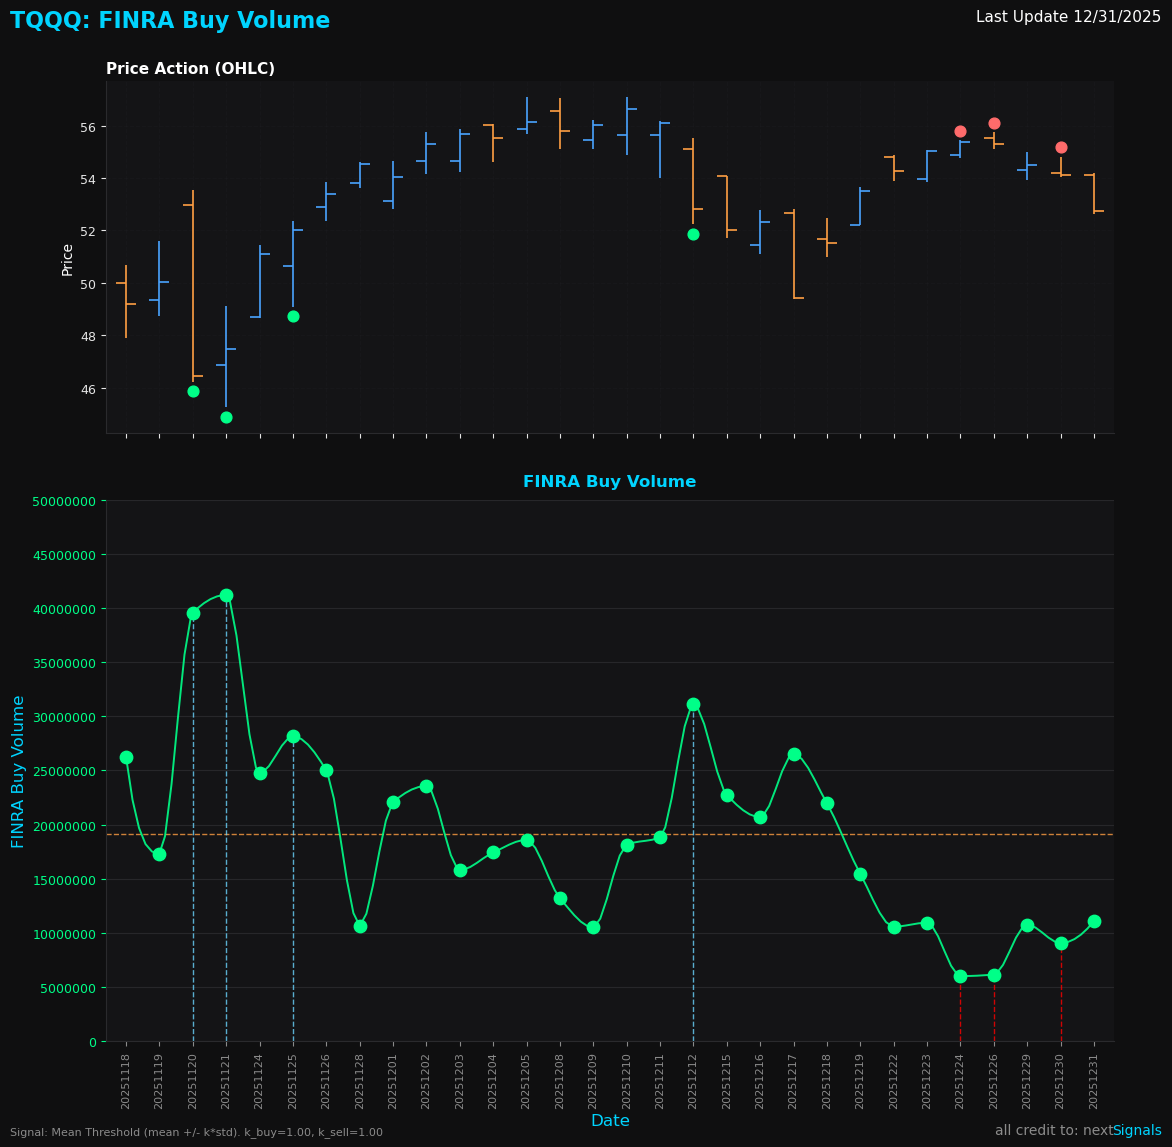

In [44]:
# Cell 4 - Two-Panel Plot (OHLC + Volume-Weighted Accumulation)
plt.style.use('dark_background')

plot_df = df.sort_values('date').copy()
if 'THRESHOLD_K_NEG' not in globals():
    THRESHOLD_K_NEG = THRESHOLD_K

market_mask = plot_df['close'].notna()
plot_df = plot_df.loc[market_mask].copy()
plot_df = plot_df.reset_index(drop=True)
if plot_df.empty:
    raise ValueError('No market days with OHLC data in the selected range.')
x_labels = plot_df['date'].dt.strftime('%Y%m%d').tolist()
if 'finra_buy_volume' not in plot_df.columns:
    raise ValueError('finra_buy_volume missing from dataset.')
accum_series = plot_df['finra_buy_volume']
if accum_series.isna().all():
    raise ValueError('finra_buy_volume is empty for the selected range.')
plot_df['vw_accum'] = pd.to_numeric(accum_series, errors='coerce')
if not plot_df['vw_accum'].equals(plot_df['finra_buy_volume']):
    raise ValueError('Panel 2 is not plotting finra_buy_volume.')

fig_width = _compute_fig_width(len(plot_df))
fig_height = fig_width * FIG_HEIGHT_RATIO
FIGSIZE = (fig_width, fig_height)
if FIGSIZE_PX is not None:
    fig_width = FIGSIZE_PX[0] / FIG_DPI
    fig_height = FIGSIZE_PX[1] / FIG_DPI
    FIGSIZE = (fig_width, fig_height)
text_scale = 1.0
if AUTO_TEXT_SCALE:
    base_width = float(BASE_FIG_WIDTH)
    if base_width > 0:
        text_scale = (fig_width / base_width) ** TEXT_SCALE_POWER
    text_scale = max(TEXT_SCALE_MIN, min(TEXT_SCALE_MAX, text_scale))
TEXT_SCALE = text_scale

fig = plt.figure(figsize=FIGSIZE)
fig.patch.set_facecolor(COLORS['background'])

# Layout tuned to keep panel 2 proportions close to the reference image
height_ratios = [1.3, 2]
fig_gs = fig.add_gridspec(
    2, 1,
    height_ratios=height_ratios,
    hspace=0.15,
    left=0.1,
    right=0.94,
    top=0.9,
    bottom=0.1,
)

ax_price = fig.add_subplot(fig_gs[0])
ax_accum = fig.add_subplot(fig_gs[1], sharex=ax_price)

# Panel 1: OHLC bar chart (plotter_chart.py styling)
_apply_axis_style(ax_price)
x_vals = np.arange(len(plot_df))
_plot_ohlc_bars(ax_price, plot_df, x_vals)
ax_price.set_ylabel('Price', color=COLORS['white'], fontsize=10 * text_scale)
ax_price.set_title('Price Action (OHLC)', color=COLORS['white'], fontsize=11 * text_scale, fontweight='bold', loc='left')
ax_price.tick_params(axis='x', labelbottom=False)
if len(x_vals) > 0:
    pad = 0.6
    ax_price.set_xlim(x_vals.min() - pad, x_vals.max() + pad)

# Panel 2: Volume-Weighted Accumulation (match attached style)
_apply_accum_axis_style(ax_accum)
accum = plot_df['vw_accum']
valid_mask = ~accum.isna()

def _compute_signal_indices(accum_series, valid_mask_series):
    if BUY_SELL_SIGNAL == 'Mean_Threshold':
        mean_val = accum_series[valid_mask_series].mean()
        std_val = accum_series[valid_mask_series].std(ddof=0)

        pos_threshold = mean_val + (THRESHOLD_K * std_val if std_val and std_val > 0 else 0.0)
        pos_idx = accum_series[valid_mask_series][accum_series[valid_mask_series] >= pos_threshold].index
        if len(pos_idx) == 0:
            top_n = min(5, len(accum_series[valid_mask_series]))
            pos_idx = accum_series[valid_mask_series].nlargest(top_n).index

        neg_threshold = mean_val - (THRESHOLD_K_NEG * std_val if std_val and std_val > 0 else 0.0)
        neg_idx = accum_series[valid_mask_series][accum_series[valid_mask_series] <= neg_threshold].index
        if len(neg_idx) == 0:
            bottom_n = min(5, len(accum_series[valid_mask_series]))
            neg_idx = accum_series[valid_mask_series].nsmallest(bottom_n).index

        return pos_idx, neg_idx, mean_val, None

    if BUY_SELL_SIGNAL == 'Rolling_Zscore':
        window = int(ROLLING_WINDOW_DAYS)
        min_periods = window if ZSCORE_MIN_PERIODS is None else int(ZSCORE_MIN_PERIODS)
        prior = accum_series.shift(1)
        rolling_mean = prior.rolling(window=window, min_periods=min_periods).mean()
        rolling_std = prior.rolling(window=window, min_periods=min_periods).std(ddof=0)
        z_scores = (accum_series - rolling_mean) / rolling_std
        ok_mask = valid_mask_series & rolling_mean.notna() & rolling_std.notna() & (rolling_std > 0)
        pos_mask = ok_mask & (z_scores >= ZSCORE_K_BUY)
        neg_mask = ok_mask & (z_scores <= -ZSCORE_K_SELL)
        return accum_series[pos_mask].index, accum_series[neg_mask].index, None, rolling_mean

    raise ValueError(f"Unknown BUY_SELL_SIGNAL mode: {BUY_SELL_SIGNAL}")

if valid_mask.any():
    _plot_smooth_line(
        ax_accum,
        x_vals,
        accum,
        COLORS['green'],
        valid_mask,
        linewidth=1.4,
        alpha=0.9,
        zorder=3,
    )
    ax_accum.scatter(
        x_vals[valid_mask],
        accum.loc[valid_mask],
        color=COLORS['green'],
        s=80,
        zorder=4,
    )

if valid_mask.any():
    max_val = accum[valid_mask].max()
else:
    max_val = 1.0

if pd.isna(max_val) or max_val <= 0:
    max_val = 1.0

y_min = 0.0
padded_max = max_val * 1.1
y_ticks = _nice_volume_ticks(padded_max)
y_max = float(y_ticks[-1])
ax_accum.set_ylim(y_min, y_max)

ax_accum.set_yticks(y_ticks)
ax_accum.grid(True, axis='y', linestyle='-', color=COLORS['grid'], alpha=0.9, linewidth=0.8)
ax_accum.set_axisbelow(True)
ax_accum.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: _format_plain_int(x)))
ax_accum.tick_params(axis='y', colors=COLORS['green'])
ax_accum.set_ylabel('FINRA Buy Volume', color=COLORS['cyan'], fontsize=12 * text_scale)
ax_accum.set_title('FINRA Buy Volume', color=COLORS['cyan'], fontsize=12 * text_scale, fontweight='bold', loc='center', pad=10 * text_scale)

if valid_mask.any():
    pos_idx, neg_idx, mean_val, rolling_mean = _compute_signal_indices(accum, valid_mask)

    if BUY_SELL_SIGNAL == 'Mean_Threshold' and mean_val is not None:
        ax_accum.axhline(
            mean_val,
            color=COLORS['orange'],
            linestyle='--',
            linewidth=1.0,
            alpha=0.8,
            zorder=2,
        )

    if BUY_SELL_SIGNAL == 'Rolling_Zscore':
        rolling_prior = accum.shift(int(ROLLING_MEAN_SHIFT_DAYS))
        rolling_mean_line = rolling_prior.rolling(
            window=int(ROLLING_MEAN_WINDOW_DAYS),
            min_periods=int(ROLLING_MEAN_WINDOW_DAYS),
        ).mean()
        rolling_mask = rolling_mean_line.notna()
        if rolling_mask.any():
            _plot_smooth_line(
                ax_accum,
                x_vals,
                rolling_mean_line,
                COLORS['orange'],
                rolling_mask,
                linewidth=1.0,
                alpha=0.8,
                zorder=2,
                linestyle='--',
            )

    price_lows = plot_df['low'].to_numpy()
    price_highs = plot_df['high'].to_numpy()
    price_min = np.nanmin(price_lows) if np.isfinite(price_lows).any() else np.nan
    price_max = np.nanmax(price_highs) if np.isfinite(price_highs).any() else np.nan
    if not np.isfinite(price_min) or not np.isfinite(price_max):
        price_min = np.nanmin(plot_df['close'].to_numpy()) if np.isfinite(plot_df['close'].to_numpy()).any() else np.nan
        price_max = np.nanmax(plot_df['close'].to_numpy()) if np.isfinite(plot_df['close'].to_numpy()).any() else np.nan
    if np.isfinite(price_min) and np.isfinite(price_max):
        offset = (price_max - price_min) * 0.03
        if not np.isfinite(offset) or offset == 0:
            offset = 1.0
        if len(pos_idx) > 0:
            pos_x = x_vals[pos_idx]
            pos_lows = plot_df.loc[pos_idx, 'low'].to_numpy()
            pos_marker_y = pos_lows - offset
            ax_price.scatter(
                pos_x,
                pos_marker_y,
                s=60,
                color=COLORS['green'],
                zorder=5,
            )
        if len(neg_idx) > 0:
            neg_x = x_vals[neg_idx]
            neg_highs = plot_df.loc[neg_idx, 'high'].to_numpy()
            neg_marker_y = neg_highs + offset
            ax_price.scatter(
                neg_x,
                neg_marker_y,
                s=60,
                color=COLORS['red'],
                zorder=5,
            )

    for idx in pos_idx:
        x_val = x_vals[idx]
        y_val = accum.loc[idx]
        ax_accum.vlines(
            x_val,
            y_min,
            y_val,
            color= "#6bd5ff",
            linestyle='--',
            linewidth=1.0,
            alpha=0.8,
            zorder=2,
        )

    for idx in neg_idx:
        x_val = x_vals[idx]
        y_val = accum.loc[idx]
        ax_accum.vlines(
            x_val,
            y_min,
            y_val,
            color= "#ff0000",
            linestyle='--',
            linewidth=1.0,
            alpha=0.8,
            zorder=2,
        )
label_step = 1
if len(x_vals) > MAX_X_LABELS:
    label_step = int(np.ceil(len(x_vals) / MAX_X_LABELS))
x_tick_positions = x_vals[::label_step]
x_tick_labels = x_labels[::label_step]
if len(x_tick_positions) > 0 and x_tick_positions[-1] != x_vals[-1]:
    x_tick_positions = np.append(x_tick_positions, x_vals[-1])
    x_tick_labels.append(x_labels[-1])

ax_accum.set_xticks(x_tick_positions)
ax_accum.set_xticklabels(x_tick_labels, rotation=90, ha='center', fontsize=8 * text_scale, color=COLORS['text_muted'])
ax_accum.tick_params(axis='x', labelbottom=True, colors=COLORS['text_muted'])
ax_accum.set_xlabel('Date', color=COLORS['cyan'], fontsize=12 * text_scale)

last_update = plot_df['date'].max()
signal_note = ''
if BUY_SELL_SIGNAL == 'Mean_Threshold':
    signal_note = (
        f"Signal: Mean Threshold (mean +/- k*std). k_buy={THRESHOLD_K:.2f}, k_sell={THRESHOLD_K_NEG:.2f}"
    )
elif BUY_SELL_SIGNAL == 'Rolling_Zscore':
    min_periods = ZSCORE_MIN_PERIODS if ZSCORE_MIN_PERIODS is not None else ROLLING_WINDOW_DAYS
    signal_note = (
        f"Signal: Rolling Z-Score (window={ROLLING_WINDOW_DAYS}, min={min_periods}, K Buy +{ZSCORE_K_BUY:.2f} / K Sell -{ZSCORE_K_SELL:.2f})"
    )
if pd.notna(last_update):
    last_update = pd.to_datetime(last_update)
    last_update_str = f"{last_update.month}/{last_update.day}/{last_update.year}"
else:
    last_update_str = 'NA'

fig.text(
    0.02,
    0.96,
    f"{TICKER}: FINRA Buy Volume",
    color=COLORS['cyan'],
    fontsize=16 * text_scale,
    fontweight='bold',
    ha='left',
    va='top',
)
fig.text(
    0.98,
    0.96,
    f"Last Update {last_update_str}",
    color=COLORS['white'],
    fontsize=11 * text_scale,
    ha='right',
    va='top',
)

fig.text(0.02, 0.02, signal_note, color=COLORS['text_muted'], fontsize=8 * text_scale, ha='left', va='bottom')
fig.text(0.94, 0.02, 'all credit to: next', color=COLORS['text_muted'], fontsize=10 * text_scale, ha='right', va='bottom')
fig.text(0.98, 0.02, 'Signals', color=COLORS['cyan'], fontsize=10 * text_scale, ha='right', va='bottom')



# Optional save
output_path = config.plot_dir / f"{TICKER.lower()}_wtd_vwbr_{START_DATE}_{END_DATE}.png"
fig.savefig(output_path, dpi=150, facecolor=COLORS['background'], edgecolor='none')

plt.show()


























